## Business case:

To recommend the top 10 similar movies for a user when he/ she searches for a movie using ITEM BASED COLLABORATIVE FILTERING ALGORITHM.

## Importing the libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


## Importing the dataset:

In [6]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")


## Basic checks and domain analysis:

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Insights:
- movieId- Once the recommendation is done, a list of all similar movie id and the corresponding movie title will be shown as the outcome.
- genres- This feature is not required for this filtering approach.


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



#### Insights:
##### The ratings dataset has
- userId- this is unique for each user.
- movieId- using this feature, the title of the movie is taken from the movies dataset
- rating- this feature shows the ratings given by each user for all the movies. This helps in predicting the top 10 similar movies.

## data preprocessing:

In [9]:
# In the ratings dataset, it is clear that the userid 1 has watched movieid 1 and 3 and rated 4.0 for both.
# But userid 1 has not rated movieid 2 at all.
# Due to the difficulty in the interpretation of this dataframe, a new dataframe is created where each column represents the unique userid and each row represents unique movieid.

In [9]:
final_dataset= ratings.pivot(index= 'movieId', columns= 'userId', values= 'rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Insights:
# Now the interpretation is quite clear
# Nan represents the missing value i.e., the user has given no rating for it.


#### Imputing the null values:

In [10]:
# Imputing Nan values with 0

final_dataset.fillna(0, inplace = True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Removing the noise from the data:

In [1]:
# To reduce the noise, some filters are added to the final dataset.
# Two conditions are used here
# 1. To qualify a movie, a minimum of ten users should have voted the movie.
# 2. To qualify a user, a minimum of 50 movies should have been voted a user.


In [11]:
# Aggregating the no of users who voted and the no of movies that were voted.

no_of_users_voted= ratings.groupby('movieId')['rating'].agg('count')
no_of_movies_voted= ratings.groupby('userId')['rating'].agg('count')


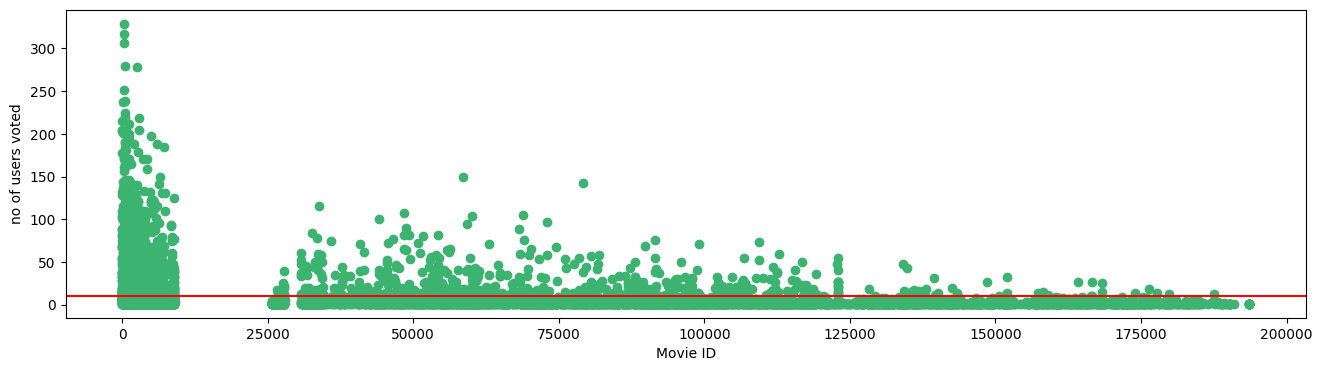

In [16]:
# visualizing the no of users who have voted above the threshold of ten

f, ax= plt.subplots(1,1, figsize= (16, 4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_of_users_voted.index, no_of_users_voted, color= 'mediumseagreen')
plt.axhline(y=10, color='r')
plt.xlabel('Movie ID')
plt.ylabel('no of users voted')
plt.show()


In [17]:
# Modifying the final dataset as per the threshold level

final_dataset= final_dataset.loc[no_of_users_voted[no_of_users_voted > 10].index, :]

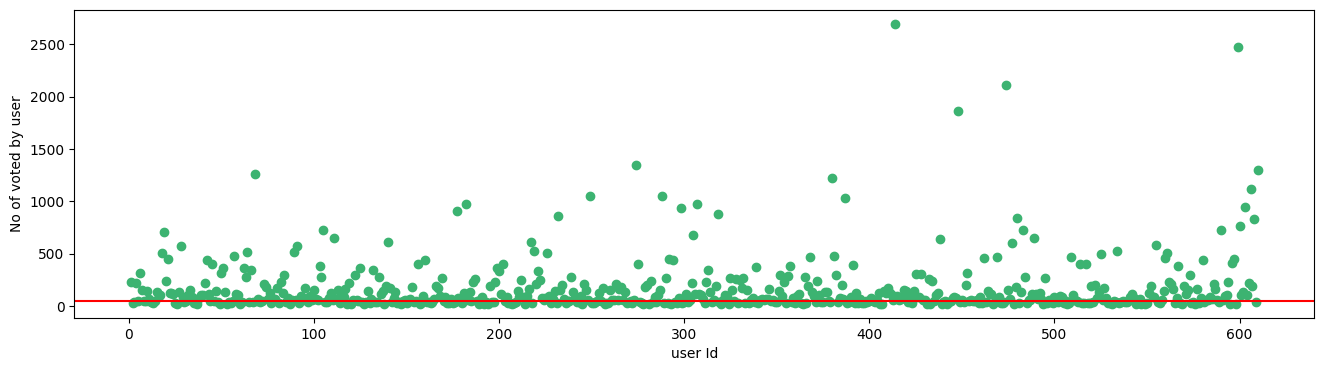

In [18]:
# visualizing the no of votes by each user as per the threshold level of 50

f, ax =plt.subplots(1,1, figsize=(16, 4))
plt.scatter(no_of_movies_voted.index, no_of_movies_voted, color= 'mediumseagreen')
plt.axhline(y= 50, color= 'r')
plt.xlabel('user Id')
plt.ylabel('No of voted by user')
plt.show()

In [19]:
# Modifying the final dataset
final_dataset= final_dataset.loc[:, no_of_movies_voted[no_of_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# this final dataset has the dimensions of (2121, 378) where most of the values are sparse.
# To reduce the sparsity, we use csr_matrix funcion from the scipy library.

csr_data= csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace= True)

## Model creation

In [22]:
# KNN algorithm is used to compute the similarity with cosine distance metric (more fast and prefereable than the pearson coefficent)

knn= NearestNeighbors(metric= 'cosine', algorithm= 'brute', n_neighbors= 20, n_jobs= -1)
knn.fit(csr_data)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [23]:
# defining a funtion to perform the following working principle:
# 1. Checking if the movie name input is in the database
# 2. Using the recommendation system to find the similar movies
# 3. sort them based on their similarity distances
# 4. Output only the ten movies with their distances from the input movie.

In [24]:
def get_movie_recommendation(movie_name):
  n_movies_to_recommend= 10
  movie_list= movies[movies['title'].str.contains(movie_name)]
  if len(movie_list):
    movie_idx= movie_list.iloc[0]['movieId']
    movie_idx= final_dataset[final_dataset['movieId'] == movie_idx].index[0]
    distances, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors= n_movies_to_recommend+1)
    rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key= lambda x: x[1])[:0:-1]
    recommend_frame= []
    for val in rec_movie_indices:
      movie_idx= final_dataset.iloc[val[0]]['movieId']
      idx= movies[movies['movieId'] == movie_idx].index
      recommend_frame.append({'Title': movies.iloc[idx]['title'].values[0], 'Distance': val[1]})
    df= pd.DataFrame(recommend_frame, index= range(1, n_movies_to_recommend+1))
    return df
  else:
    return "No movies found, please check your input"




In [25]:
# prediction

get_movie_recommendation('Iron Man')

,Title,Distance
1,Up (2009),0.368857
2,Guardians of the Galaxy (2014),0.368758
3,Watchmen (2009),0.368558
4,Star Trek (2009),0.366029
5,Batman Begins (2005),0.362759
6,Avatar (2009),0.310893
7,Iron Man 2 (2010),0.307492
8,WALL·E (2008),0.298138
9,"Dark Knight, The (2008)",0.285835
10,"Avengers, The (2012)",0.285319


In [26]:
# Insights:

# Thus the the above recommended movies are mostly belong to superhero or animation genre
# which are idea for kids since the input movie is  Iron Man

In [27]:
get_movie_recommendation('Jumanji')

,Title,Distance
1,Casper (1995),0.474253
2,Stargate (1994),0.469654
3,"Nightmare Before Christmas, The (1993)",0.462612
4,Home Alone (1990),0.443432
5,Beauty and the Beast (1991),0.435007
6,Aladdin (1992),0.425428
7,Jurassic Park (1993),0.420563
8,Mrs. Doubtfire (1993),0.416164
9,"Mask, The (1994)",0.413743
10,"Lion King, The (1994)",0.377013


In [28]:
# the above recommendations are mostly adventure and fantasy movies as per the input 'Jumanji'.